In [1]:
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
import torch
from transformers.utils import is_flash_attn_2_available

import os
import pandas as pd
from openai import OpenAI
from neo4j import GraphDatabase
import ast
import re
import json

In [2]:
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "password")
model_id = "gemma-3-12b-it"

device = "cuda" if torch.cuda.is_available() else "cpu"
client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio"
)

Entity Relationship Extraction

In [3]:
problems_path = os.path.join(os.getcwd(), "mathinfo.csv")
problems = pd.read_csv(problems_path)

In [4]:
ER_EXTRACTION_PROMPT = """
You are a helpful assistant extracting structured information from math problems and categorizing them.
Given the following math problem and solution, extract the following:

Title:
    - A brief title of the problem.

Description:
    - A brief description or summary of the problem.

Entities:
Each entity should have:
    - title: The name or description of the entity.
    - type: The category or label (e.g., 'geometric shape', 'rate', 'equation', 'number', 'variable', etc.).
    - description: A brief explanation or context from the text.

    Include all relevant values and variables as entities.

Relationships:
Each relationship should have:
    - source: The title of the source entity.
    - target: The title of the target entity.
    - type: The type of relationship (e.g., 'is a', 'is part of', 'is related to', 'multiplies', etc.).
    - description: A brief explanation of the relationship from the text.

    Each relationship should describe how two entities are related to each other.
    Include relationships that describe how the entities interact or are connected in the context of the problem.

Communities:
    - Suggest one or more communities the problem might belong to (e.g., "Calculus", "Geometry", "Rates of Change", etc.).
    - The community should be relevant to the nature of the problem (e.g., "Calculus" for differentiation problems, "Geometry" for problems related to shapes, etc.).

The output should be in JSON format, structured as follows:
{
    "title": "string",
    "description": "string",
    "entities": [
        {
            "title": "string",
            "type": "string",
            "description": "string"
        }
    ],
    "relationships": [
        {
            "source": "string",
            "target": "string",
            "type": "string",
            "description": "string"
        }
    ],
    "communities": [
        "string"  # List of community names the problem might belong to.
    ]
}

Do not include any other text or explanations in the output. The output should be clean and valid JSON.

Text:
{Insert TextUnit Here}
"""

json_results = []

for index, row in problems.iterrows():
    problem = row["Problem"]
    solution = row["Solution"]
    
    query = f"Problem: {problem}\nSolution: {solution}"
    messages = [
        {"role": "system", "content": ER_EXTRACTION_PROMPT},
        {"role": "user", "content": query}
    ]

    response = client.chat.completions.create(
        model=model_id,
        messages=messages
    )
    results = response.choices[0].message.content
    results = re.sub(r"```(json)?", "", results).strip("'").strip()
    result_json = json.loads(results)
    json_results.append(result_json)
    print(f"Processed problem {index + 1}/{len(problems)}")

Processed problem 1/13
Processed problem 2/13
Processed problem 3/13
Processed problem 4/13
Processed problem 5/13
Processed problem 6/13
Processed problem 7/13
Processed problem 8/13
Processed problem 9/13
Processed problem 10/13
Processed problem 11/13
Processed problem 12/13
Processed problem 13/13


In [9]:
class MathProblemGraph:
    def __init__(self, uri, user, pwd):
        self.driver = GraphDatabase.driver(uri, auth=(user, pwd))

    def close(self):
        self.driver.close()

    # Create problem node
    def create_problem(self, title, description):
        with self.driver.session() as session:
            session.execute_write(self._create_problem, title, description)

    @staticmethod
    def _create_problem(tx, title, description):
        # Check if the problem already exists
        result = tx.run("MATCH (p:Problem {title: $title}) RETURN p", title=title)
        existing_problem = result.single()

        if not existing_problem:
            # If problem doesn't exist, create it
            tx.run("""
                CREATE (p:Problem {title: $title, description: $description})
            """, title=title, description=description)

    # Create entities with dynamic check (no stray nodes)
    def create_entity(self, title, entity_type, description):
        with self.driver.session() as session:
            session.execute_write(self._create_entity, title, entity_type, description)

    @staticmethod
    def _create_entity(tx, title, entity_type, description):
        # Check if the entity already exists
        result = tx.run("MATCH (e:Entity {title: $title}) RETURN e", title=title)
        existing_entity = result.single()

        if not existing_entity:
            tx.run("""
                CREATE (e:Entity {title: $title, type: $entity_type, description: $description})
            """, title=title, entity_type=entity_type, description=description)

    # Create relationships between entities
    def create_relationship(self, source_title, target_title, relationship_type, description):
        with self.driver.session() as session:
            session.execute_write(self._create_relationship, source_title, target_title, relationship_type, description)

    @staticmethod
    def normalize_relationship_type(raw_type):
        # Convert to uppercase and replace spaces with underscores
        cleaned = raw_type.upper().replace(" ", "_")
        # Ensure it’s valid Cypher syntax: starts with a letter, only letters, digits, underscores
        if not re.match(r"^[A-Z_][A-Z0-9_]*$", cleaned):
            raise ValueError(f"Invalid relationship type: {raw_type}")
        return cleaned

    @staticmethod
    def _create_relationship(tx, source_title, target_title, relationship_type, description):
        # Sanitize or validate the relationship_type first!
        rel_type = MathProblemGraph.normalize_relationship_type(relationship_type)
        query = f"""
            MERGE (a:Entity {{title: $source_title}})
            MERGE (b:Entity {{title: $target_title}})
            MERGE (a)-[r:{rel_type}]->(b)
            ON CREATE SET r.description = $description
        """
        tx.run(query, source_title=source_title, target_title=target_title, description=description)

    # Create problem-community relationship
    def add_problem_to_community(self, problem_title, community_name):
        with self.driver.session() as session:
            session.execute_write(self._add_problem_to_community, problem_title, community_name)

    @staticmethod
    def _add_problem_to_community(tx, problem_title, community_name):
        # Check if community node exists
        result = tx.run("MATCH (c:Community {name: $community_name}) RETURN c", community_name=community_name)
        existing_community = result.single()

        if not existing_community:
            tx.run("""
                CREATE (c:Community {name: $community_name})
            """, community_name=community_name)

        tx.run("""
            MATCH (p:Problem {title: $problem_title}), (c:Community {name: $community_name})
            MERGE (p)-[:BELONGS_TO]->(c)
        """, problem_title=problem_title, community_name=community_name)

    # Indexing the entities, relationships, and community
    def index_problem_data(self, problem_title, problem_description, er_json):
        self.create_problem(problem_title, problem_description)

        for entity in er_json["entities"]:
            self.create_entity(entity["title"], entity["type"], entity["description"])
            self.link_problem_to_entity(problem_title, entity["title"])

        for relationship in er_json["relationships"]:
            self.create_relationship(relationship["source"], relationship["target"], relationship["type"], relationship["description"])

        for community in er_json["communities"]:
            self.add_problem_to_community(problem_title, community)

    def get_problems_in_community(self, community_name):
        with self.driver.session() as session:
            result = session.execute_read(self._get_problems_in_community, community_name)
            return result

    @staticmethod
    def _get_problems_in_community(tx, community_name):
        result = tx.run("""
            MATCH (p:Problem)-[:BELONGS_TO]->(c:Community {name: $community_name})
            RETURN p.title AS problem_title, p.description AS problem_description
        """, community_name=community_name)

        return [{"problem_title": record["problem_title"], "problem_description": record["problem_description"]} for record in result]
    
    def link_problem_to_entity(self, problem_title, entity_title):
        with self.driver.session() as session:
            session.execute_write(self._link_problem_to_entity, problem_title, entity_title)

    @staticmethod
    def _link_problem_to_entity(tx, problem_title, entity_title):
        tx.run("""
            MATCH (p:Problem {title: $problem_title}), (e:Entity {title: $entity_title})
            MERGE (p)-[:USES]->(e)
        """, problem_title=problem_title, entity_title=entity_title)

    def get_all_problems(self):
        with self.driver.session() as session:
            result = session.execute_read(self._get_all_problems)
            return result

    @staticmethod
    def _get_all_problems(tx):
        result = tx.run("""
            MATCH (p:Problem)
            RETURN p.title AS problem_title, p.description AS problem_description
            ORDER BY p.title
        """)
        return [
            {"problem_title": record["problem_title"], "problem_description": record["problem_description"]}
            for record in result
        ]


db = MathProblemGraph(uri="bolt://localhost:7687", user="neo4j", pwd=NEO4J_PASSWORD)

for result in json_results:
    title = result['title']
    description = result['description']

    db.index_problem_data(result['title'], result['description'], result)


In [10]:
print("Problems in the 'Calculus' Community:")
problems_in_calculus = db.get_problems_in_community("Calculus")
for problem in problems_in_calculus:
    print(f"Title: {problem['problem_title']}\nDescription: {problem['problem_description']}\n")

print("All Problems:")
all_problems = db.get_all_problems()
for problem in all_problems:
    print(f"Title: {problem['problem_title']}\nDescription: {problem['problem_description']}\n")

db.close()

Problems in the 'Calculus' Community:
Title: Balloon Volume Increase Rate
Description: A balloon's radius increases at a given rate, and we need to find how fast its volume is increasing when the radius reaches a specific value.

Title: Pool Volume Increase Rate
Description: A rectangular swimming pool's volume increase rate is calculated given its dimensions and the rate of change of its depth.

Title: Ladder Sliding Down Wall
Description: A ladder leaning against a vertical wall slides, and we need to find the speed at which the top of the ladder is sliding down when the bottom is 6 meters from the wall.

Title: Water Level Rising in Tank
Description: A tank with a square base is being filled with water, and the problem asks to find the rate at which the water level is rising given the filling rate and the dimensions of the tank.

Title: Derivative of a Quadratic Function
Description: Find the derivative of the function f(x) = 3x^2 + 5x - 7.

Title: Double Integral Evaluation
Descrip

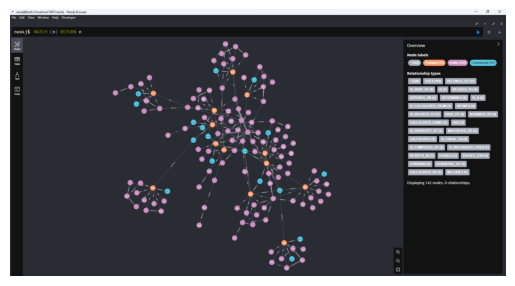

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = os.path.join(os.getcwd(), "knowledge_graph.png")
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()